In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Read data from csv exported files

In [2]:
dino_df = pd.read_csv("B31B0190_001_full.csv", skiprows=14, usecols=['Peildatum', 'Stand (cm t.o.v NAP)'])
dino_df

,Peildatum,Stand (cm t.o.v NAP)
0,28-08-1973,-603
1,15-10-1973,-577
2,14-12-1973,-573
3,29-04-1974,-579
4,28-08-1974,-587
...,...,...
146,29-05-2000,-588
147,28-06-2000,-590
148,28-07-2000,-593
149,28-08-2000,-593


In [3]:
bro_df = pd.read_csv("GLD000000057428_full.csv", skiprows=9, usecols=['tijdstip meting', 'waterstand'])
bro_df

,tijdstip meting,waterstand
0,1985-12-13T12:00:00+01:00,-5.95
1,1986-03-21T12:00:00+01:00,-5.94
2,1986-04-28T12:00:00+02:00,-5.94
3,1986-08-28T12:00:00+02:00,-6.87
4,1986-10-14T12:00:00+01:00,-7.28
...,...,...
99,2000-07-28T12:00:00+02:00,-5.93
100,2000-08-28T12:00:00+02:00,-5.93
101,2000-09-28T12:00:00+02:00,-5.98
102,NaN,NaN


## Plot

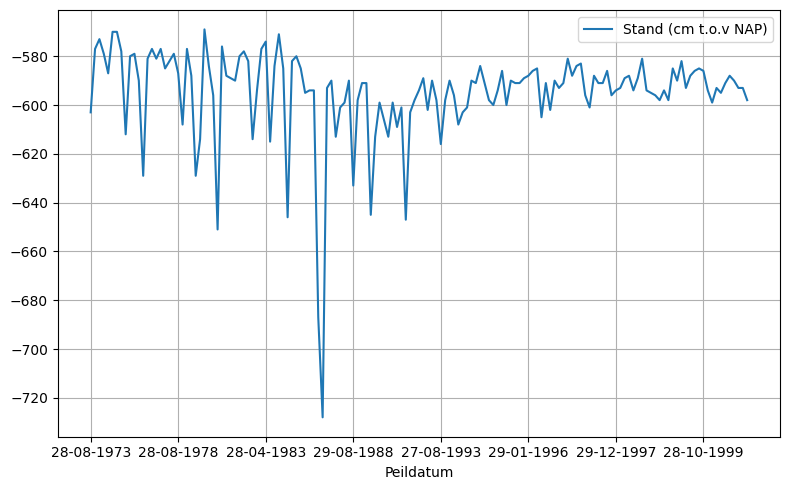

In [4]:
dino_df.plot(x='Peildatum', y='Stand (cm t.o.v NAP)', kind='line', figsize=(8, 5), grid=True)
plt.tight_layout()

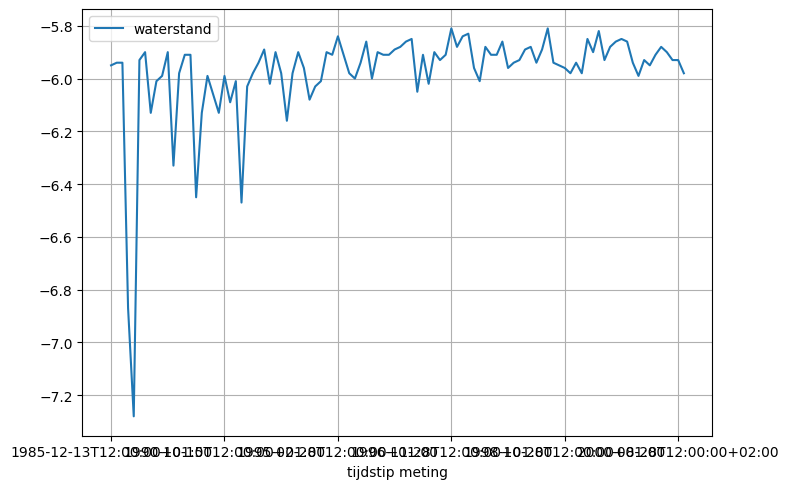

In [5]:
bro_df.plot(x='tijdstip meting', y='waterstand', kind='line', figsize=(8, 5), grid=True)
plt.tight_layout()

## Methods for time-series analysis


In [6]:
bro_series = bro_df['waterstand'].dropna().values
dino_series = dino_df['Stand (cm t.o.v NAP)'].dropna().values

In [7]:
# Normalization
s1 = (bro_series - np.mean(bro_series))/np.std(bro_series)
s2 = (dino_series - np.mean(dino_series))/np.std(dino_series)

### Euclidean distance

In [8]:
corr = np.correlate(s1, s2, mode='full')  # normalized cross-correlation is auto if series are z-normalized
lag = np.argmax(corr) - (len(s1)-1)

In [10]:
corr

array([-2.15275639e-02, -1.57608763e-02,  3.51227755e-03,  8.06057349e-01,
        7.10726357e-01, -1.06035880e+00, -1.82280575e+00, -3.18759655e+00,
       -3.37235996e+00, -1.30135162e+00, -5.30417399e-01,  5.18888584e-01,
        1.06903233e+00, -2.48270177e+00, -5.91324845e+00, -5.34401710e+00,
       -4.74798680e+00, -2.79949006e+00, -4.65691312e+00, -6.56906009e+00,
       -5.20176513e+00, -3.63839402e+00, -1.06105859e+00,  4.17776171e-02,
        3.08703695e-02, -8.07132816e-01, -3.54757501e+00, -6.15673666e+00,
       -9.03655976e+00, -2.47781342e+00, -3.96719904e+00, -5.12610542e+00,
       -5.06219445e+00, -2.83023134e+00, -2.57507822e+00, -5.09069641e+00,
       -6.25383765e+00, -2.23030396e+00, -5.17936835e+00, -3.73233280e+00,
       -1.91096942e-01, -2.62073502e+00, -7.81391150e+00, -6.79192187e+00,
       -5.59520265e+00, -6.94794865e+00, -4.01815741e+00, -5.61064292e+00,
       -2.63907161e+00, -1.44622842e-01, -1.48417667e+00,  1.10486683e+00,
       -5.86413269e+00, -

In [ ]:
# cannot calculate euclidean distance directly because the time series have different lengths
print(len(s1))
print(len(s2))


102
151


### Dynamic Time Warping

In [12]:
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

/home/luisa/micromamba/envs/ts/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [13]:
#s1 = TimeSeriesScalerMeanVariance().fit_transform(series1.reshape(1,-1))[0]
#s2 = TimeSeriesScalerMeanVariance().fit_transform(series2.reshape(1,-1))[0]
dist = dtw(s1, s2)  # DTW on z-normalized series

In [14]:
dist

6.951306337796141

### Wavelets

In [6]:
import pywt

In [13]:
x=bro_df['waterstand'].dropna().values
x

array([-5.95, -5.94, -5.94, -6.87, -7.28, -5.93, -5.9 , -6.13, -6.01,
       -5.99, -5.9 , -6.33, -5.98, -5.91, -5.91, -6.45, -6.13, -5.99,
       -6.06, -6.13, -5.99, -6.09, -6.01, -6.47, -6.03, -5.98, -5.94,
       -5.89, -6.02, -5.9 , -5.98, -6.16, -5.98, -5.9 , -5.96, -6.08,
       -6.03, -6.01, -5.9 , -5.91, -5.84, -5.91, -5.98, -6.  , -5.94,
       -5.86, -6.  , -5.9 , -5.91, -5.91, -5.89, -5.88, -5.86, -5.85,
       -6.05, -5.91, -6.02, -5.9 , -5.93, -5.91, -5.81, -5.88, -5.84,
       -5.83, -5.96, -6.01, -5.88, -5.91, -5.91, -5.86, -5.96, -5.94,
       -5.93, -5.89, -5.88, -5.94, -5.89, -5.81, -5.94, -5.95, -5.96,
       -5.98, -5.94, -5.98, -5.85, -5.9 , -5.82, -5.93, -5.88, -5.86,
       -5.85, -5.86, -5.94, -5.99, -5.93, -5.95, -5.91, -5.88, -5.9 ,
       -5.93, -5.93, -5.98])

In [14]:
cA, cD = pywt.dwt(x, 'db2')

In [15]:
print(cA)

[-8.41103516 -8.28490733 -9.4800356  -9.00568014 -8.54926774 -8.41662631
 -8.72019944 -8.32192842 -8.84867985 -8.53632678 -8.60911797 -8.49715718
 -8.89258617 -8.48382635 -8.38171064 -8.3861006  -8.6179228  -8.37265197
 -8.53831438 -8.49736789 -8.33748245 -8.32823796 -8.48029082 -8.35213227
 -8.39310365 -8.35740156 -8.31980478 -8.31504317 -8.45156688 -8.40724579
 -8.34912931 -8.27927306 -8.25553969 -8.45907761 -8.34998374 -8.32350125
 -8.41431686 -8.34032448 -8.37706683 -8.2662392  -8.40810022 -8.43837209
 -8.41889265 -8.29789808 -8.33101198 -8.2947093  -8.28357012 -8.43871884
 -8.40500435 -8.32807704 -8.36532706 -8.43931943]


In [16]:
print(cD)

[-6.12372436e-03  4.50449604e-01 -9.17307679e-01  2.96390927e-01
  3.00295842e-03  2.42082048e-01  3.42901881e-02  2.69858640e-01
 -2.43588650e-02  2.71759997e-02  8.87350994e-02  2.37506259e-01
  7.18869658e-02 -3.53553391e-03 -9.74470142e-02  7.41781958e-02
  1.70886320e-03  4.70951079e-02 -7.51073144e-03  4.63086925e-02
  5.72620460e-02 -2.41481457e-02 -2.00120201e-02 -8.74410042e-02
  9.40541835e-03  2.24143868e-03  3.53553391e-03 -1.37031391e-01
 -7.87290894e-02 -4.73671727e-03  7.17509334e-02  2.53839914e-04
 -2.05196999e-02  5.39803520e-02 -2.80304313e-02 -3.85441212e-02
 -1.31947922e-02  3.76896896e-02 -2.87239349e-02 -3.07795498e-02
  4.82962913e-03  3.08724617e-02  6.49337055e-02  7.49397156e-02
 -6.21663621e-03  1.09533535e-02 -5.43022082e-03  2.44019856e-02
 -2.93494222e-03  1.13001053e-02  2.02658600e-02 -3.06186218e-02]


### Signal processing

In [22]:
from scipy.signal import stft, detrend, savgol_filter

In [105]:
detrend_bro = detrend(bro_series)
s_avgol = savgol_filter(bro_series, 6, 3)

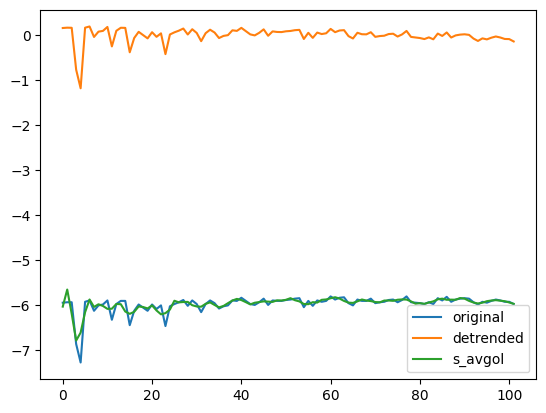

In [106]:
plt.plot(bro_series, label='original')
plt.plot(detrend_bro, label='detrended')
plt.plot(s_avgol, label='s_avgol')
plt.legend()

In [112]:
def find_peaks_1d(x, neighborhood=1, prom_window=50, min_prominence=0.0, top_k=None):
    """
    Simple peak picker (pure numpy).
    - x: 1D array
    - neighborhood: number of samples on each side a value must exceed to be considered a local max
    - prom_window: search radius to compute a crude prominence (in samples)
    - min_prominence: minimum prominence (peak - max(base_left, base_right))
    - top_k: keep only top_k peaks by magnitude (per call)
    Returns: list of (idx, value, prominence) sorted by idx
    Notes: O(n * neighborhood) which is fine for small neighborhood (e.g. 3..31).
    """
    x = np.asarray(x, dtype=float)
    n = len(x)
    if n == 0:
        return []

    # don't consider edges where neighborhood would go out of bounds
    lo = neighborhood
    hi = n - neighborhood
    candidates = []
    for i in range(lo, hi):
        window = x[i-neighborhood : i+neighborhood+1]
        # is x[i] strictly greater than others in window (tie-breaking: allow equality on right)
        center = window[neighborhood]
        if center <= np.max(np.delete(window, neighborhood)):
            continue
        # compute crude prominence: drop to highest base on left/right within prom_window
        left_start = max(0, i - prom_window)
        right_end = min(n, i + prom_window + 1)
        # left base: minimal value between i and nearest higher (approx by min)
        left_min = np.min(x[left_start:i]) if i - left_start > 0 else center
        right_min = np.min(x[i+1:right_end]) if right_end - (i+1) > 0 else center
        base = max(left_min, right_min)
        prominence = center - base
        if prominence >= min_prominence:
            candidates.append((i, center, prominence))

    if not candidates:
        return []

    # optionally keep top_k by magnitude
    if top_k is not None and len(candidates) > top_k:
        candidates.sort(key=lambda t: t[1], reverse=True)
        candidates = candidates[:top_k]
        candidates.sort(key=lambda t: t[0])  # sort back by time

    return candidates

def find_time_peaks(series, smooth_windows=(11,31,91), prominence=0.5, top_k_per_scale=50):
    peaks = []
    for scale_idx, w in enumerate(smooth_windows):
        w = int(w) if int(w) % 2 == 1 else int(w) + 1
        s_s = savgol_filter(series, w, polyorder=3)
        raw_peaks = find_peaks_1d(s_s, neighborhood=max(1, w//8),
                                  prom_window=w*2, min_prominence=prominence,
                                  top_k=top_k_per_scale)
        for idx, val, prom in raw_peaks:
            peaks.append((int(idx), int(scale_idx), float(val)))
    peaks.sort(key=lambda x: x[0])
    return peaks

In [177]:
peaks = find_time_peaks(bro_series, smooth_windows=(5,7,15), prominence=0.05, top_k_per_scale=10)
print(peaks)

[(1, 0, -5.804571428571427), (6, 0, -5.86142857142857), (7, 1, -5.893809523809528), (10, 2, -5.957076923076956), (13, 0, -5.851714285714285), (14, 2, -6.075022624434423), (16, 2, -6.066769230769264), (26, 1, -5.914761904761909), (30, 2, -5.942407239819037), (40, 0, -5.870857142857142), (40, 1, -5.877142857142861), (51, 1, -5.858095238095242), (52, 0, -5.844571428571428), (61, 1, -5.8333333333333375), (61, 2, -5.877873303167453), (62, 0, -5.842571428571428), (63, 2, -5.880108597285101), (68, 1, -5.88619047619048), (76, 1, -5.881428571428575), (77, 0, -5.858857142857142), (85, 0, -5.846), (86, 1, -5.868095238095242), (88, 2, -5.8694751131222045), (90, 0, -5.846571428571427), (90, 1, -5.851904761904766), (97, 0, -5.886857142857142), (98, 1, -5.89619047619048)]


In [ ]:
df_peaks = pd.DataFrame(peaks, columns=['idx', 'scale', 'val']).astype({'idx': int, 'scale': int, 'val': float})
df_peaks = df_peaks.groupby('idx', as_index=False).agg({'val': 'max', 'scale': 'first'})
idxs = df_peaks['idx'].values
peak_vals = bro_series[idxs]

    idx  scale       val
0     1      0 -5.804571
1     6      0 -5.861429
2     7      1 -5.893810
3    10      2 -5.957077
4    13      0 -5.851714
5    14      2 -6.075023
6    16      2 -6.066769
7    26      1 -5.914762
8    30      2 -5.942407
9    40      0 -5.870857
10   40      1 -5.877143
11   51      1 -5.858095
12   52      0 -5.844571
13   61      1 -5.833333
14   61      2 -5.877873
15   62      0 -5.842571
16   63      2 -5.880109
17   68      1 -5.886190
18   76      1 -5.881429
19   77      0 -5.858857
20   85      0 -5.846000
21   86      1 -5.868095
22   88      2 -5.869475
23   90      0 -5.846571
24   90      1 -5.851905
25   97      0 -5.886857
26   98      1 -5.896190
    idx       val  scale
0     1 -5.804571      0
1     6 -5.861429      0
2     7 -5.893810      1
3    10 -5.957077      2
4    13 -5.851714      0
5    14 -6.075023      2
6    16 -6.066769      2
7    26 -5.914762      1
8    30 -5.942407      2
9    40 -5.870857      0
10   51 -5.858095      1


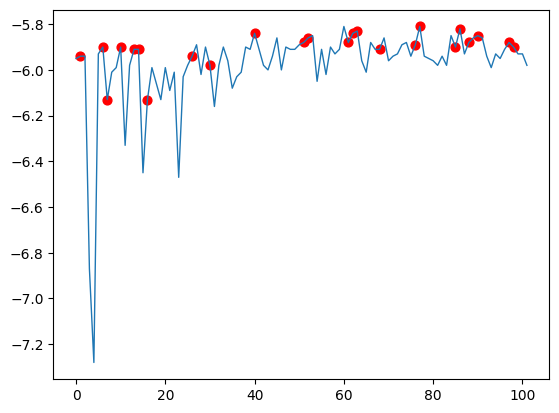

In [179]:
plt.plot(bro_series, '-', lw=1, label='signal (samples)')
plt.scatter(idxs, peak_vals, c='red', s=40, label='detected peaks')

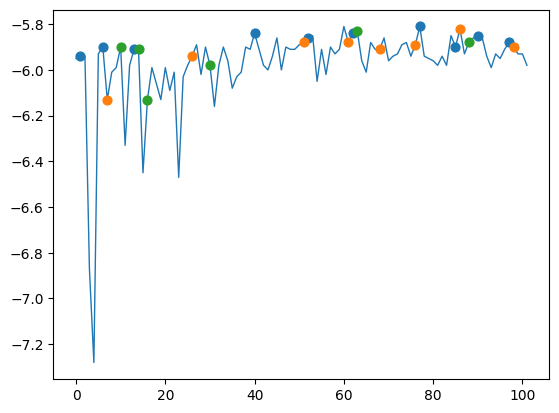

In [ ]:
plt.plot(bro_series, '-', lw=1, label='signal')
scales = sorted(df_peaks['scale'].unique())
cmap = plt.get_cmap('tab10')
color_map = {s: cmap(i % cmap.N) for i, s in enumerate(scales)}
for s in scales: # plot with different color the peaks of different scales `smooth_windows` argument.
    sub = df_peaks[df_peaks['scale'] == s]
    idxs = sub['idx'].values
    vals = bro_series[idxs]
    plt.scatter(idxs, vals, c=[color_map[s]], s=40, label=f'scale {s}', zorder=5)